# Drug Embeddings


To determine how we could use a trained model to evaluate the effects of state change on cell organization, we utilize data from a small drug perturbation experiment. 
The drug dataset consists of images of cells that were fluorescently-tagged with one of three subcellular structures: Microtubules, Golgi, or tight junctions, and exposed to one of two drugs: Brefelden (5.0 $\mu m$) or Paclitaxel (5.0 $\mu m$).    
Our main question is whether the trained model can sensibly be applied to these drug data and provide biological insights by evaluating on low-dimensional representations of reference and target structures.

We embed the images of the drug-perturbed cells into the latent representation $\zRef$ and $\zTarget$ of the trained IC model. 
Figure \ref{fig:drugs}b  shows this embedding in the first two dimensions of latent space for the reference channels (membrane and DNA) as well as for the three structures. 
We observed that the treated and untreated cells occupy the same space for the reference model $\modelRef$. 
Note that the structure model is conditional on the reference (membrane and DNA), and if the treated cells were substantially different from the untreated cells with regards to their cell and nuclear morphology, we could not sensibly apply the conditional model. 
Effects were detected by computing the Euclidean distance between treated and untreated centroids, and statistical significance was determined by bootstrap sampling (fig \ref{fig:drugs}c).
We were able to detect changes in cell and nuclear shape for both drugs, as well as changes in localization pattern with Paclitaxel treated microtubules and Tight junctions, as well as Brefelden treated Golgi.
These results align with previous literature as Paclitaxel known to interfere the depolymerization of microtubules \cite{horwitz1994taxol}, and the requirement of microtubules for tight junction formation \cite{glotfelty2014microtubules}, whereas Brefelden is known to disassemble Golgi \cite{chardin1999brefeldin}.

In [1]:
import json
import integrated_cell
from integrated_cell import model_utils, utils
import os
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from integrated_cell.utils.plots import tensor2im, imshow

gpu_ids = [3]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()
    
#load the reference model
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'

ref_model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04'
ref_suffix = '_94544'    

networks, dp_ref, args_ref = utils.load_network_from_dir(ref_model_dir, parent_dir, suffix=ref_suffix)

ref_enc = networks['enc']
ref_dec = networks['dec']

#load the target model
target_model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/"
target_suffix = '_93300'

networks, dp_target, args_target = utils.load_network_from_dir(target_model_dir, parent_dir, suffix=target_suffix)
    
target_enc = networks['enc']
target_dec = networks['dec']


results_dir = '{}/results/ref_target_drug_embeddings/'.format(parent_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
print("Results dir: {}".format(results_dir))

save_dir = results_dir

recon_loss = utils.load_losses(args_target)['crit_recon']

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth
Results dir: /allen/aics/modeling/gregj/results/integrated_cell//results/ref_target_drug_embeddings/


## Load the drug dataproviders

In [2]:
from integrated_cell.utils import load_drug_data_provider

dp_ref_drugs = load_drug_data_provider(dp_ref, args_ref)
dp_target_drugs = load_drug_data_provider(dp_target, args_target)

#sanity check
assert dp_ref_drugs.__len__('test') == dp_target_drugs.__len__('test')

reading csv manifest
DrugID-Concentration combinations
[[ 1.   5. ]
 [ 2.   5. ]
 [ 3.   0.1]
 [ 4.  25. ]
 [ 5.  50. ]
 [ 6.   0.5]]
reading csv manifest
DrugID-Concentration combinations
[[ 1.   5. ]
 [ 2.   5. ]
 [ 3.   0.1]
 [ 4.  25. ]
 [ 5.  50. ]
 [ 6.   0.5]]


/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:564: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ] = "S-Nitro-Blebbistatin"
/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:585: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug, conc
/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

## Get embeddings for everything, and put them like this so everything is in one location

In [ ]:
import integrated_cell.metrics.embeddings_reference as get_embeddings_reference
import integrated_cell.metrics.embeddings_target as get_embeddings_target

batch_size = 32

drug_structures = np.array(['Microtubules', 'Golgi', 'Tight junctions'])
drugs = ['Brefeldin 5.0 μM', 'Paclitaxel 5.0 μM']
drug_colors = ['blue', 'pink']

#get embeddings, klds, everything
embeddings_path = "{}/embeddings.pth".format(results_dir)
if not os.path.exists(embeddings_path):
    embeddings_ref_untreated = get_embeddings_reference.get_latent_embeddings(ref_enc, ref_dec, dp_ref, recon_loss, batch_size=batch_size)
    embeddings_target_untreated = get_embeddings_target.get_latent_embeddings(target_enc, target_dec, dp_target, recon_loss, batch_size=batch_size)
    
    embeddings_ref_drugs = get_embeddings_reference.get_latent_embeddings(ref_enc, ref_dec, dp_ref_drugs, recon_loss, batch_size=batch_size)
    embeddings_target_drugs = get_embeddings_target.get_latent_embeddings(target_enc, target_dec, dp_target_drugs, recon_loss, batch_size=batch_size)
        
    torch.save([embeddings_ref_untreated, embeddings_target_untreated, embeddings_ref_drugs, embeddings_target_drugs], embeddings_path)
    
else: 
    [embeddings_ref_untreated, embeddings_target_untreated, embeddings_ref_drugs, embeddings_target_drugs] = torch.load(embeddings_path)

# Mark which data we want to show ('legal_inds') based on drug_structures and drugs
for [dp, embedding_ref, embedding_target] in [[dp_target, embeddings_ref_untreated, embeddings_target_untreated], [dp_target_drugs, embeddings_ref_drugs, embeddings_target_drugs]]:
    mode = 'test'

    label_dict = {}

    label_dict['structure_inds'] = dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode)
    label_dict['structure_names'] = dp_target.label_names[label_dict['structure_inds']]

    structure_legal_inds = np.zeros(label_dict['structure_names'].shape) > 0
    
    for structure in drug_structures:
        structure_legal_inds[label_dict['structure_names'] == structure] = 1
    
    label_dict['legal_inds'] = structure_legal_inds
    label_dict['dp_inds'] = np.arange(len(label_dict['legal_inds']))
    
    
    embedding_ref.update(label_dict)
    embedding_target.update(label_dict)
    
    
label_dict = {}
drug_names = dp_target_drugs.drug_names[dp_target_drugs.drug_info['test']]
drug_legal_inds = np.zeros(embedding_ref['legal_inds'].shape) > 0 

for drug in drugs:
    drug_legal_inds[drug_names == drug] = 1


label_dict['drug_names'] = drug_names
label_dict['legal_inds'] = np.all(np.vstack([embeddings_ref_drugs['legal_inds'], drug_legal_inds]), 0)
    
for embedding in [embeddings_ref_drugs, embeddings_target_drugs]:
    embedding.update(label_dict)

    
def trim_on_legal_inds(embedding, legal_inds):
    if isinstance(embedding, dict):
        for k in embedding:
            embedding[k] = trim_on_legal_inds(embedding[k], legal_inds)
    else:
        embedding = embedding[legal_inds]
            
    return embedding

for embedding in [embeddings_ref_untreated, embeddings_target_untreated, embeddings_ref_drugs, embeddings_target_drugs]:
    embedding = trim_on_legal_inds(embedding, embedding['legal_inds'])

## compute klds for each of the embeddings

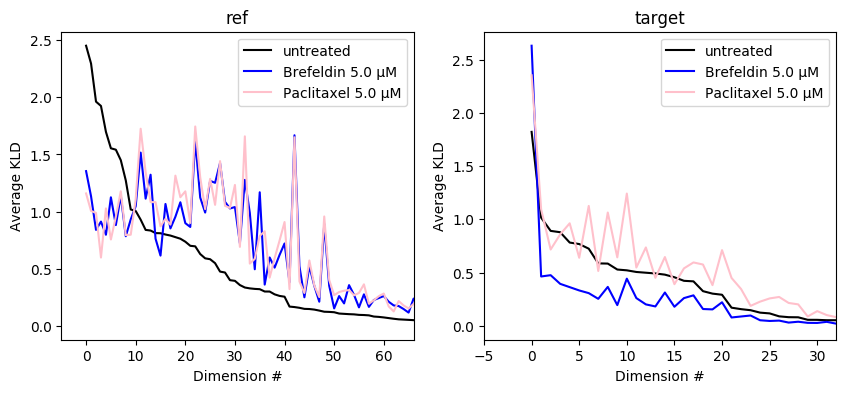

In [30]:
import numpy as np

from integrated_cell.models.bvae import kl_divergence
from integrated_cell.utils.plots import plot_dim_variation

def dim_klds(mus, sigmas):
    kl_dims = list()
    for mu, sigma in zip(mus, sigmas):
        _, kl_dim, _ = kl_divergence(mu.unsqueeze(0), sigma.unsqueeze(0))
        
        kl_dims.append(kl_dim)
    
    return np.vstack(np.vstack(kl_dims))

for embedding, ref_or_target in zip([embeddings_ref_untreated, embeddings_target_untreated, embeddings_ref_drugs, embeddings_target_drugs], ['ref', 'target', 'ref', 'target']):
    embedding['test'][ref_or_target]['klds_by_dim'] = dim_klds(embedding['test'][ref_or_target]['mu'], embedding['test'][ref_or_target]['sigma'])


embeddings_all = [['ref', embeddings_ref_untreated, embeddings_ref_drugs], ['target', embeddings_target_untreated ,embeddings_target_drugs]]    
    
plt.figure(figsize=[10,4])

sorted_inds = {}

info_thresh = 0.05
n_dims = {}



c = 1
for ref_or_target, embeddings_untreated, embeddings_drugs in embeddings_all:
        
    plt.subplot(1,2,c)
    c+=1
    
    kld_stds_untreated = np.mean(np.abs(embeddings_untreated['test'][ref_or_target]['klds_by_dim']), axis = 0)
    sorted_inds[ref_or_target] = np.argsort(kld_stds_untreated)[::-1]

    plt.plot(kld_stds_untreated[sorted_inds[ref_or_target]], label='untreated', color = 'black')
    
    for i, (drug_name, drug_color) in enumerate(zip(drugs, drug_colors)):
        
        klds = embeddings_drugs['test'][ref_or_target]['klds_by_dim'][embeddings_ref_drugs['drug_names'] == drug_name,:]
        kld_stds_drugs = np.std(klds, axis = 0)

        plt.plot(kld_stds_drugs[sorted_inds[ref_or_target]], label=drug_name, color=drug_color)
        
    
        
    n_dims[ref_or_target] = np.where(kld_stds_untreated[sorted_inds[ref_or_target]] > 0.05)[0][-1]
        
    plt.xlim(-5,n_dims[ref_or_target])
    plt.title(ref_or_target)
    
    plt.xlabel('Dimension rank')
    plt.ylabel('Average KLD')    
    
    plt.legend()
    
    


In [60]:
print(sorted_inds["ref"][:2])
print(sorted_inds["target"][:2])

[ 71 419]
[196 262]


In [32]:
import matplotlib as mpl
mpl.rc('image', cmap='hsv')

n_pairs = 2
point_size = 2
fig_scale = 4

## Plot embeddings for cell and nuclear shape across all drugs

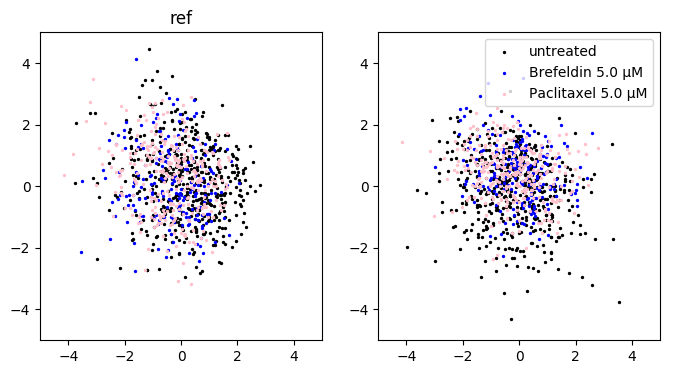

In [33]:

drug_colors = ['blue', 'pink']
ref_or_target = 'ref'
embeddings_untreated = embeddings_ref_untreated
embeddings_drugs = embeddings_ref_drugs

# for ref_or_target, embeddings_untreated, embeddings_drugs in embeddings_all:
plt.figure(figsize=[fig_scale*n_pairs, fig_scale])
plt.title(ref_or_target)

positions_untreated = embeddings_untreated['test'][ref_or_target]['mu'].numpy()[:, sorted_inds[ref_or_target]][:, 0:n_dims[ref_or_target]]
positions_treated = embeddings_drugs['test'][ref_or_target]['mu'].numpy()[:, sorted_inds[ref_or_target]][:, 0:n_dims[ref_or_target]]

structure = "Reference"

position_dict = {}
position_dict[structure] = {}

c = 1    
for i in list(range(0, n_pairs*2, 2)):
    plt.subplot(1, n_pairs, c)
    c += 1

    if c == 2:
        plt.title(ref_or_target)

    position_dict[structure]['untreated'] = {}
    position_dict[structure]['untreated']['positions'] = positions_untreated
    position_dict[structure]['untreated']['dp_index'] = embeddings_untreated['dp_inds'][np.arange(0, positions_untreated.shape[0])]
    
    assert(position_dict[structure]['untreated']['positions'].shape[0] == len(position_dict[structure]['untreated']['dp_index']))
        
    plt.scatter(positions_untreated[:, i], positions_untreated[:, i+1], label = 'untreated', s=point_size, color='k')
        
    for drug_name, drug_color in zip(drugs, drug_colors):
        
        valid_indices = embeddings_drugs['drug_names'] == drug_name
        
        positions = positions_treated[valid_indices]
        
        position_dict[structure][drug_name] = {}
        position_dict[structure][drug_name]['positions'] = positions
        position_dict[structure][drug_name]['dp_index'] = embeddings_drugs['dp_inds'][np.arange(0, sum(valid_indices))]
        
        assert(position_dict[structure][drug_name]['positions'].shape[0] == len(position_dict[structure][drug_name]['dp_index']))
        
        plt.scatter(positions[:, i], positions[:, i+1], label = drug_name, s=point_size, c = drug_color)


    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
#     plt.axis('equal')
plt.legend()
plt.show()
plt.close()
    


## Plot embeddings for each structure shape across all drugs

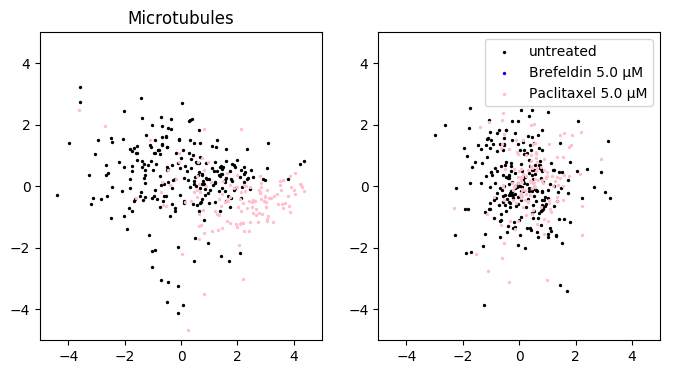

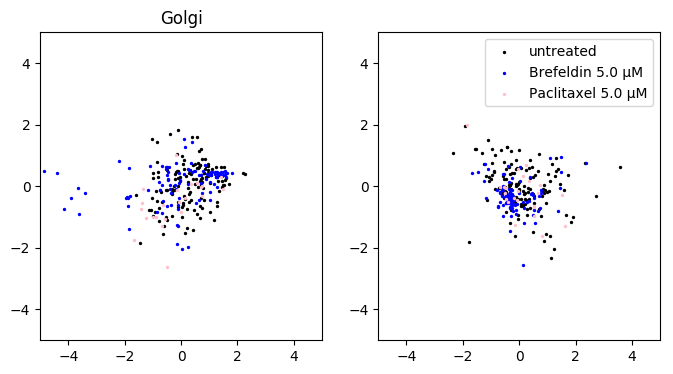

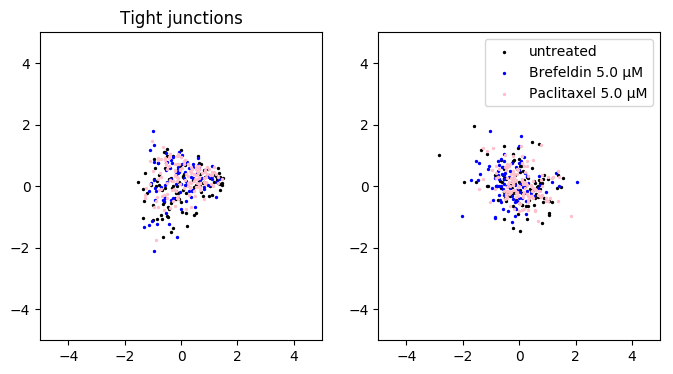

In [34]:
ref_or_target = 'target'
embeddings_untreated = embeddings_target_untreated
embeddings_drugs = embeddings_target_drugs

positions_untreated = embeddings_untreated['test'][ref_or_target]['mu'].numpy()[:, sorted_inds[ref_or_target]][:, 0:n_dims[ref_or_target]]
positions_treated = embeddings_drugs['test'][ref_or_target]['mu'].numpy()[:, sorted_inds[ref_or_target]][:, 0:n_dims[ref_or_target]]

for structure in drug_structures:
    position_dict[structure] = {}
    
    plt.figure(figsize=[fig_scale*n_pairs, fig_scale])
    plt.title(ref_or_target)

    structure_inds_untreated = embeddings_untreated['structure_names'] == structure
    structure_inds_drugs = embeddings_drugs['structure_names'] == structure
    

    c = 1
    for i in list(range(0, n_pairs*2, 2)):
        plt.subplot(1, n_pairs, c)
        c += 1

        if c == 2:
            plt.title(structure)
            
        positions = positions_untreated[structure_inds_untreated]

        plt.scatter(positions[:, i], positions[:, i+1], label = 'untreated', s=point_size, color='k')        
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)

        position_dict[structure]['untreated'] = {}
        position_dict[structure]['untreated']['positions'] = positions
        position_dict[structure]['untreated']['dp_index'] = embeddings_untreated['dp_inds'][np.where(structure_inds_untreated)[0]]

        assert(position_dict[structure]['untreated']['positions'].shape[0] == len(position_dict[structure]['untreated']['dp_index']))

            
        for drug_name, drug_color in zip(drugs, drug_colors):

            valid_indices = (embeddings_drugs['drug_names'] == drug_name) * structure_inds_drugs
            
            positions = positions_treated[valid_indices]

            plt.scatter(positions[:, i], positions[:, i+1], label = drug_name, s=point_size, color = drug_color)
            
            position_dict[structure][drug_name] = {}
            position_dict[structure][drug_name]['positions'] = positions
            position_dict[structure][drug_name]['dp_index'] = embeddings_drugs['dp_inds'][np.where(valid_indices)[0]]
            
            assert(position_dict[structure][drug_name]['positions'].shape[0] == len(position_dict[structure][drug_name]['dp_index']))


    plt.legend()
    plt.show()
    plt.close()



In [35]:
drug_structures

array(['Microtubules', 'Golgi', 'Tight junctions'], dtype='<U15')

In [36]:
print(drug_name)
print(structure)

inds = position_dict[structure][drug_name]['dp_index']

_, structure_labels, _ = dp_target_drugs.get_sample('test', inds)

print(structure_labels)

assert(np.all(dp_target.label_names[structure_labels] == structure))

Paclitaxel 5.0 μM
Tight junctions
tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23])


## Statistical tests to see if effects are real

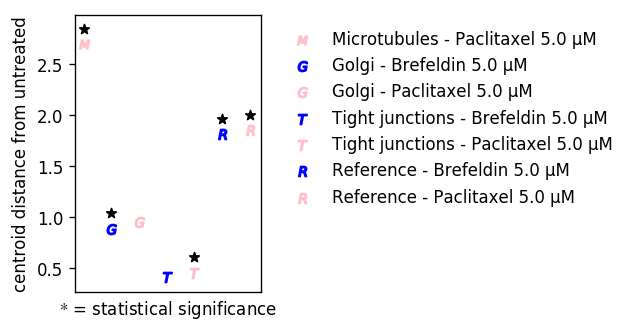

In [37]:
import scipy.spatial.distance as distance

def get_medoid(x):
    #returns medoid row of matrix x
    dmat = distance.squareform(distance.pdist(x))
    ds = np.sum(dmat, 1)
    medoid = x[np.argmin(ds)]
    
    return medoid
    

def get_oids(f1, f2, dmeth):
    #returns the *oids defined by dmeth
    
    if dmeth == 'centroid':
        c1 = np.mean(f1,0)
        c2 = np.mean(f2,0)
        
    elif dmeth == 'medoid':
        c1 = get_medoid(f1)
        c2 = get_medoid(f2)
        
    return c1, c2
    

def distance_stat_test(f1, f2, n_iter = 10000, dmeth = 'medoid'):
    # computes distance metric between f1 and f2, then performs a 
    # permutation test by sampling same-batch-size from combined
    # pool 
    #
    # assumes that inputs are numpy arrays
    
    n_dat_1 = f1.shape[0]
    n_dat_2 = f2.shape[0]
    
    n_dat = n_dat_1 + n_dat_2

    f_all = np.concatenate([f1, f2], 0)    
    
    d_test = {}
    
    c1, c2 = get_oids(f1, f2, dmeth)
    
    d_test['distance'] = distance.euclidean(c1, c2)
    d_test['c1'] = c1
    d_test['c2'] = c2
    d_test['vector'] = c1 - c2

    
    d_random = {}
    for j in range(n_iter):

        shuffle_inds = torch.randperm(n_dat)
        
        f1 = f_all[shuffle_inds[0:n_dat_1]]
        f2 = f_all[shuffle_inds[n_dat_1:]]
        
        c1, c2 = get_oids(f1, f2, dmeth)
        
        d_random[j] = distance.euclidean(c1, c2)

    distances_null = torch.Tensor([d_random[j] for j in d_random])
    
    d_test['distance_null'] = distances_null
    d_test['distance_p-val'] = torch.mean((distances_null >= d_test['distance']).float()).item()   

    return d_test

offset = 0.15

k = 3

bonferroni_correction = len(drug_structures) * len(np.unique(embeddings_drugs['drug_names'])) + len(drug_structures)

alpha_level = 0.05

ds = {}

structure_markers = ['$M$', '$G$', '$T$']
significance_marker = '*'

drug_colors = ['blue', 'pink']

dmeths = ['medoid', 'centroid']
dmeths = ['centroid']

for dmeth in dmeths:
    
    ds[dmeth] = {}

    plt.figure(figsize=[fig_scale*0.5, fig_scale*0.75], dpi = 120)

    c = 0
    for structure, structure_marker in zip(drug_structures, structure_markers):
        ds[dmeth][structure] = {}

        for drug_name, drug_color in zip(np.unique(embeddings_drugs['drug_names']), drug_colors):

            f1 = position_dict[structure]['untreated']['positions']
            f2 = position_dict[structure][drug_name]['positions']
            
            if len(f2) == 0: continue

            ds[dmeth][structure][drug_name] = distance_stat_test(f1, f2, dmeth  = dmeth)
            ds[dmeth][structure][drug_name]['color'] = drug_color

            dist = ds[dmeth][structure][drug_name]['distance']

            if (ds[dmeth][structure][drug_name]['distance_p-val']*bonferroni_correction) < alpha_level:
                plt.scatter(c, dist+offset, marker = significance_marker, c = 'k')

            plt.scatter(c, dist, label = "{} - {}".format(structure, drug_name), c = drug_color, marker=structure_marker)
            c+=1

    structure = 'Reference'
    ds[dmeth][structure] = {}
    for drug_name, drug_color in zip(np.unique(embeddings_drugs['drug_names']), drug_colors):
        f1 = position_dict[structure]['untreated']['positions']
        f2 = position_dict[structure][drug_name]['positions']

        ds[dmeth][structure][drug_name] = distance_stat_test(f1, f2, dmeth = dmeth)
        ds[dmeth][structure][drug_name]['color'] = drug_color
        
        dist = ds[dmeth][structure][drug_name]['distance']

        if (ds[dmeth][structure][drug_name]['distance_p-val']*bonferroni_correction) < alpha_level:
            plt.scatter(c, dist+offset, marker = significance_marker, c = 'k')

        plt.scatter(c, ds[dmeth][structure][drug_name]['distance'], label = "{} - {}".format(structure, drug_name), c = drug_color, marker='$R$')

        c+=1


    plt.xticks([], [])
    plt.ylabel('{} distance from untreated'.format(dmeth))
    plt.xlabel('$\\mathcal{*}$ = statistical significance')
    plt.gca().legend(bbox_to_anchor=(1.05, 1.0), frameon=False)
#     plt.tight_layout()

    plt.savefig("{}/sigtest_{}.png".format(results_dir, dmeth), dpi=120, bbox_inches = "tight")
    
    plt.show()

    plt.close()
    
    

In [120]:
bonferroni_correction

9

## Same as above but with a bar graph

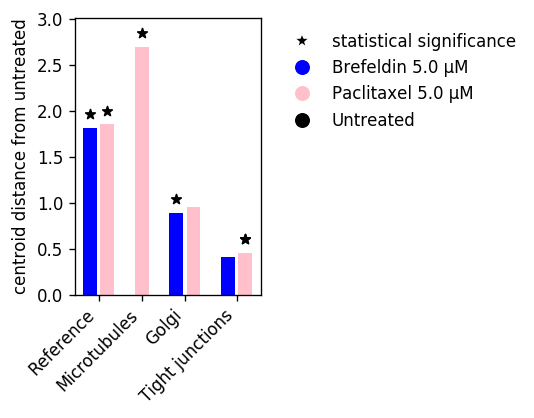

In [38]:
from matplotlib.lines import Line2D

import scipy.spatial.distance as distance
from matplotlib import cm

ds = {}

for dmeth in dmeths:
    
    ds[dmeth] = {}

    plt.figure(figsize=[fig_scale*0.5, fig_scale*0.75], dpi = 120)

    c = 0
    
    structure = 'Reference'
    ds[dmeth][structure] = {}
    for drug_name, drug_color in zip(np.unique(embeddings_drugs['drug_names']), drug_colors):
        f1 = position_dict[structure]['untreated']['positions']
        f2 = position_dict[structure][drug_name]['positions']

        ds[dmeth][structure][drug_name] = distance_stat_test(f1, f2, dmeth = dmeth)
        ds[dmeth][structure][drug_name]['color'] = drug_color
        
        dist = ds[dmeth][structure][drug_name]['distance']

        if (ds[dmeth][structure][drug_name]['distance_p-val']*bonferroni_correction) < alpha_level:
            plt.scatter(c, dist+offset, marker = significance_marker, c = 'k')
            stat_sig_coords = [c, dist+offset]

#         plt.scatter(c, ds[dmeth][structure][drug_name]['distance'], label = "{} - {}".format(structure, drug_name), c = drug_color, marker='$R$')
        plt.bar(c, ds[dmeth][structure][drug_name]['distance'], label = "{} - {}".format(structure, drug_name), color = drug_color, tick_label=structure)

        c+=1

    c+=1

    
    for structure, structure_marker in zip(drug_structures, structure_markers):
        ds[dmeth][structure] = {}

        for drug_name, drug_color in zip(np.unique(embeddings_drugs['drug_names']), drug_colors):

            f1 = position_dict[structure]['untreated']['positions']
            f2 = position_dict[structure][drug_name]['positions']
            
            if len(f2) == 0: continue

            ds[dmeth][structure][drug_name] = distance_stat_test(f1, f2, dmeth  = dmeth)
            ds[dmeth][structure][drug_name]['color'] = drug_color

            dist = ds[dmeth][structure][drug_name]['distance']

            if (ds[dmeth][structure][drug_name]['distance_p-val']*bonferroni_correction) < alpha_level:
                plt.scatter(c, dist+offset, marker = significance_marker, c = 'k')
                stat_sig_coords = [c, dist+offset]

#             plt.scatter(c, dist, label = "{} - {}".format(structure, drug_name), c = drug_color, marker=structure_marker)
            plt.bar(c, dist, label = "{} - {}".format(structure, drug_name), color = drug_color, tick_label=structure)
    
            c+=1
        c+=1


    
    plt.scatter(stat_sig_coords[0], stat_sig_coords[1], marker = significance_marker, c = 'k', label='statistical significance')

    #hardcoded x positions, im sorry
    x_pos = np.array([0.5, 3, 5.5, 8.5])
    
    plt.xticks(x_pos, np.hstack([['Reference'], drug_structures]), rotation=45, ha='right')
    plt.ylabel('{} distance from untreated'.format(dmeth))
#     plt.xlabel('$\\mathcal{*}$ = statistical significance')

    colors = cm.Paired([255, 0])    
    legend_elements = [ Line2D([0], [0], marker=significance_marker, color = 'w', markerfacecolor='k', markersize=10, label='statistical significance')]
    
    for drug_name, drug_color in zip(np.unique(embeddings_drugs['drug_names']), drug_colors):
        legend_element = Line2D([0], [0], marker='o', color = 'w', markerfacecolor=drug_color, markersize=10, label=drug_name)
        legend_elements.append(legend_element)
        
    legend_element = Line2D([0], [0], marker='o', color = 'w', markerfacecolor='k', markersize=10, label='Untreated')
    legend_elements.append(legend_element)

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), frameon=False)

    plt.savefig(f"{results_dir}/sigtest_bar_{dmeth}.png", dpi=120, bbox_inches = "tight")
    
    plt.show()
    plt.close()
    
    

In [39]:
f"{results_dir}/sigtest_bar_{dmeth}.png"

'/allen/aics/modeling/gregj/results/integrated_cell//results/ref_target_drug_embeddings//sigtest_bar_centroid.png'

Microtubules
Golgi
Tight junctions


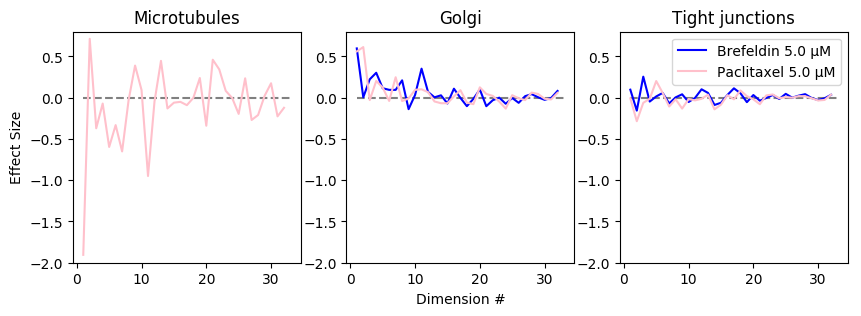

In [40]:
dmeth = 'centroid'

plt.figure(figsize=[10,3])
plt.title('$\Delta$ effect across each dimension')


c = 0
for structure in drug_structures:

        
    print(structure)
    c += 1
    plt.subplot(1, len(drug_structures), c)

    plt.title(structure)
    
    first_key = next(iter(ds[dmeth][structure]))
    len_vector = len(ds[dmeth][structure][first_key]['vector'])
    
    plt.plot([1, len_vector+1], [0,0], linestyle='--', color ='gray')
    
    for drug_name in ds[dmeth][structure]:

        vector = ds[dmeth][structure][drug_name]['vector']
        plt.plot(np.arange(len(vector)) + 1, vector, label=drug_name, color = ds[dmeth][structure][drug_name]['color'])
        
    plt.ylim([-2, 0.8])

    if c == 1:
        plt.ylabel('Effect Size')

    if c == 2:
        plt.xlabel('Dimension #')

    if c == 3: 
        plt.legend()


## Sample images along direction of effect for Paclitaxel and Microtubules

In [41]:
import scipy

drug_name = 'Paclitaxel 5.0 μM'
structure = 'Microtubules'

c1 = ds['centroid'][structure][drug_name]['c1']
c2 = ds['centroid'][structure][drug_name]['c2']

p1 = position_dict[structure]['untreated']['positions']
p2 = position_dict[structure][drug_name]['positions']

samples_all = np.vstack([p1,p2])
samples_is_treated = np.hstack([np.zeros(p1.shape[0]) == 1, np.ones(p2.shape[0])])
samples_index = np.hstack([position_dict[structure]['untreated']['dp_index'], position_dict[structure][drug_name]['dp_index']])

assert(samples_all.shape[0] == len(samples_is_treated))
assert(samples_all.shape[0] == len(samples_index))

vector = c2 - c1

n_samples = 25

relative_distances = np.linspace(-4, 3, n_samples)

dist_meth = 'projection'

ims ={}

for relative_distance in relative_distances:
    position_target = c1 + (relative_distance * vector)
    
    if dist_meth == 'nearest':
        position_target = c1 + (relative_distance * vector)
        dists = scipy.spatial.distance.cdist(np.expand_dims(position_target,0), samples_all)
    elif dist_meth == 'projection':
        position_target = relative_distance
        dists = abs(np.dot(samples_all, vector/np.linalg.norm(vector)) - position_target)
    
    d_min_index = np.argmin(dists)

    position_actual = samples_all[d_min_index]
    
    is_treated = samples_is_treated[d_min_index]
    index = samples_index[d_min_index]
    
    if structure == "Reference":
        if is_treated:            
            im = dp_ref_drugs.get_sample('test', [index])
        else:
            im = dp_ref.get_sample('test', [index])
    
    else:
        if is_treated:
            im,_,_ = dp_target_drugs.get_sample('test', [index])
        else:
            im,_,_ = dp_target.get_sample('test', [index])

    ims[relative_distance] = {}
    ims[relative_distance]['im'] = im
    ims[relative_distance]['position_target'] = position_target
    ims[relative_distance]['position_actual'] = position_actual
    ims[relative_distance]['is_treated'] = is_treated        
    ims[relative_distance]['dp_indexindex'] = index        
    

In [53]:
vector.shape

(32,)

[-4.0, -3.7083333333333335, -3.4166666666666665, -3.125, -2.833333333333333, -2.5416666666666665, -2.25, -1.958333333333333, -1.6666666666666665, -1.375, -1.083333333333333, -0.7916666666666665, -0.5, -0.20833333333333304, 0.08333333333333393, 0.375, 0.666666666666667, 0.9583333333333339, 1.25, 1.541666666666667, 1.833333333333334, 2.125, 2.416666666666667, 2.708333333333334, 3.0]


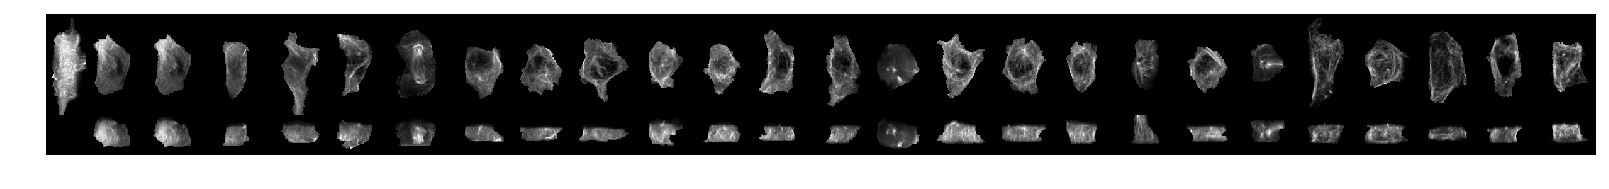

In [42]:
from integrated_cell.utils.plots import imshow

im = torch.cat([ims[relative_distance]['im']/torch.max(ims[relative_distance]['im']) for relative_distance in ims], 3)

print([relative_distance for relative_distance in ims])

plt.figure(figsize=[20,20])
imshow(im)
plt.close()

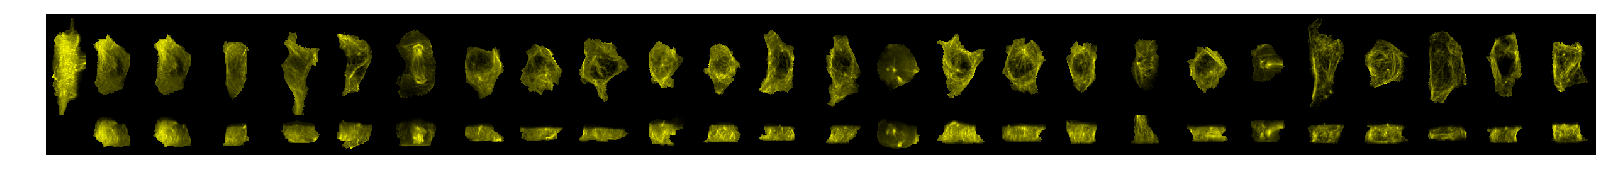

In [43]:
im_color = im.repeat([1,3,1,1,1])

im_color[:,[0,2]] = 0

plt.figure(figsize=[20,20])
imshow(im_color)
plt.close()



## Pretty plots

In [98]:
fig_scale

4

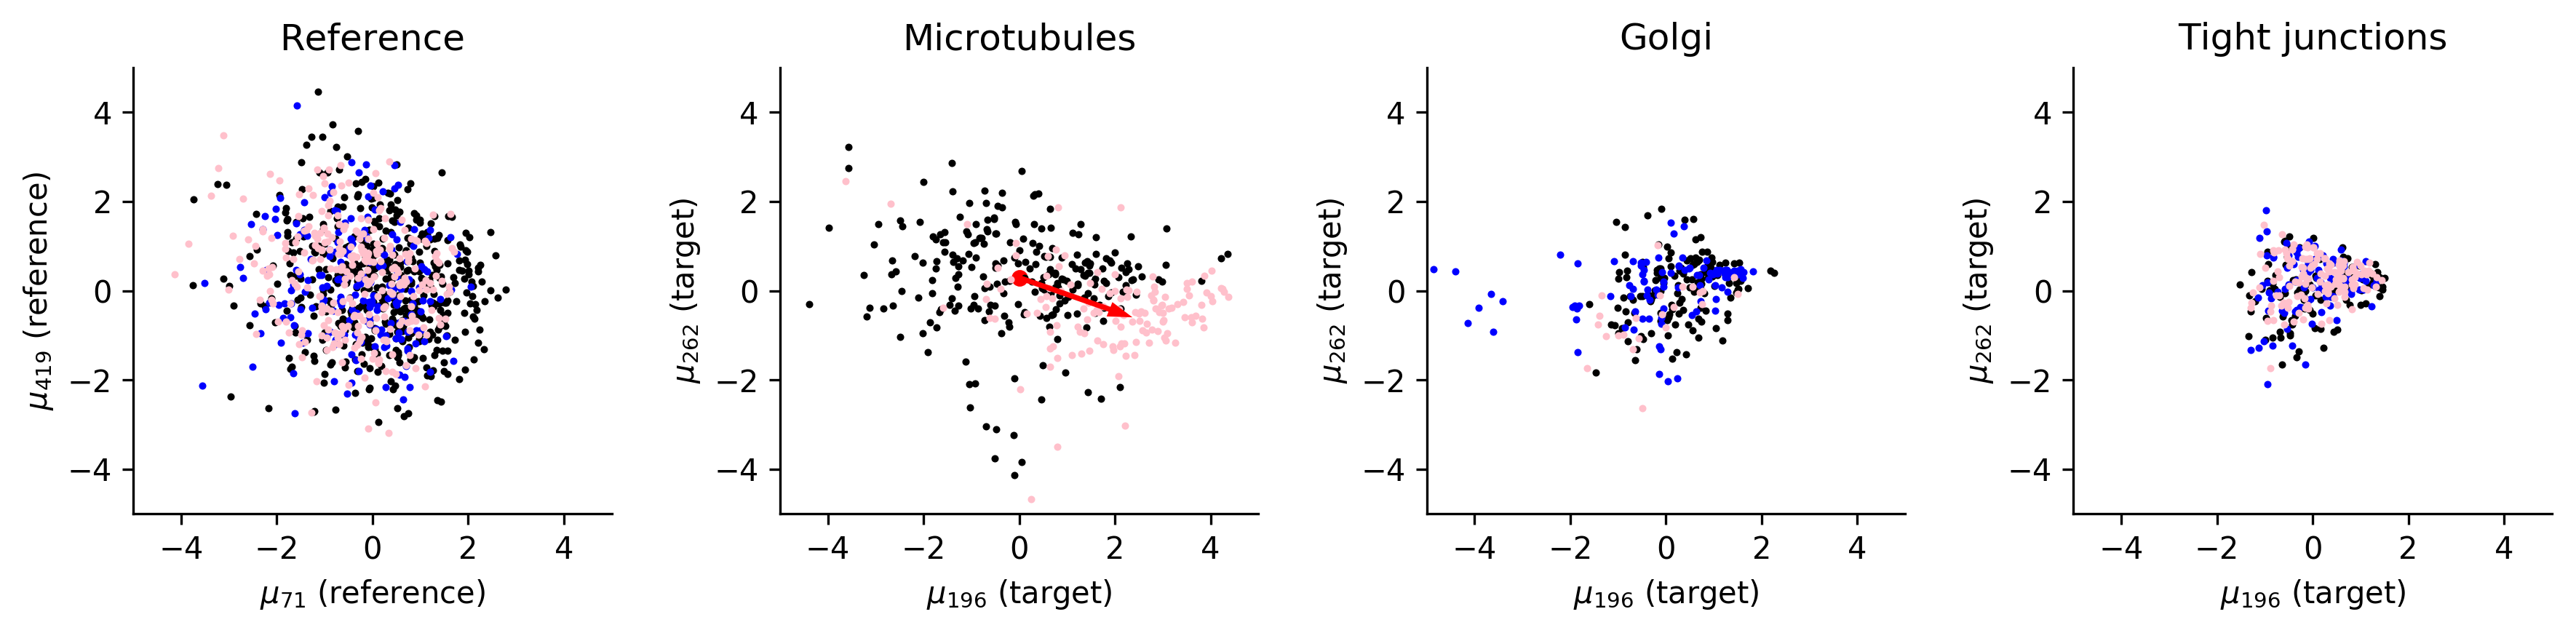

In [119]:
import seaborn as sns

drug_colors = ['blue', 'pink']
ref_or_target = 'ref'
embeddings_untreated = embeddings_ref_untreated
embeddings_drugs = embeddings_ref_drugs

structures_to_plot = np.hstack([['Reference'], drug_structures])

fig, axs = plt.subplots(1, len(structures_to_plot), figsize=[3*len(structures_to_plot), 3], dpi=300)

for i, (structure, ax) in enumerate(zip(structures_to_plot, axs)):
    
    ax.set_title(structure)
    positions_untreated = position_dict[structure]['untreated']['positions']
    
    if structure == "Microtubules":
        c1 = ds['centroid'][structure]['Paclitaxel 5.0 μM']['c1'][0:2]
        c2 = ds['centroid'][structure]['Paclitaxel 5.0 μM']['c2'][0:2]
        starts = np.array([c1[0], c2[0]])
        stops = np.array([c1[1], c2[1]])
        ax.scatter(c1[0], c1[1], color= 'r', s=20)
        ax.arrow(c1[0], c1[1], c2[0]-c1[0], c2[1]-c1[1], color ='r', width = 0.05, head_width = 0.25)
    
    ax.scatter(positions_untreated[:, 0], positions_untreated[:, 1], label = 'untreated', s=point_size, color='k')
                
    for drug_name, drug_color in zip(drugs, drug_colors):
        positions = position_dict[structure][drug_name]['positions']
        ax.scatter(positions[:, 0], positions[:, 1], label = drug_name, s=point_size, c = drug_color)
        
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    if structure == "Reference":
        ax.set(
            xlabel=r"$\mu_{71}$ (reference)",
            ylabel=r"$\mu_{419}$ (reference)",
        );
    else:
        ax.set(
            xlabel=r"$\mu_{196}$ (target)",
            ylabel=r"$\mu_{262}$ (target)",
        );

sns.despine()
fig.tight_layout()
plt.savefig('5b_embeddings.png', dpi=300, bbox_inches = "tight");
plt.show()
plt.close()

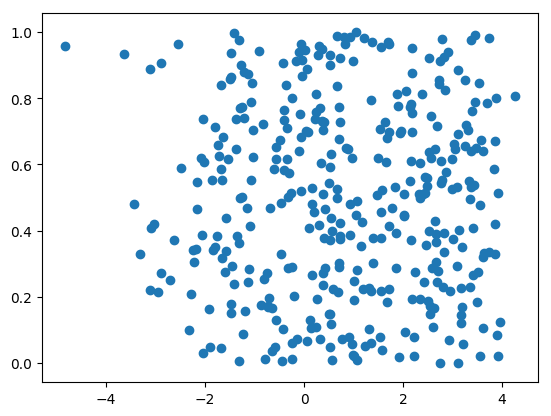

In [45]:
plt.scatter(np.dot(samples_all, vector/np.linalg.norm(vector)), np.random.rand(samples_all.shape[0]))

Text(0,0.5,'Effect Size')

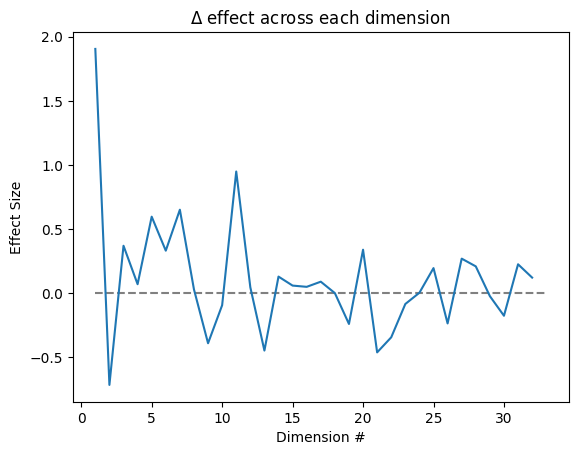

In [46]:
plt.plot([1, len(vector)+1], [0,0], linestyle='--', color ='gray')
plt.plot(np.arange(len(vector)) + 1, vector)

plt.title('$\Delta$ effect across each dimension')
plt.xlabel('Dimension #')
plt.ylabel('Effect Size')



[ 1.9169406  -0.42654994  0.43233004  0.1404982   0.48419794  0.37013856
  0.7324777   0.08757497 -0.3151739  -0.01769596  0.8476967   0.05149076
 -0.47365645  0.04682734 -0.08733975  0.05204441  0.08490856  0.06434608
 -0.13155952  0.2663281  -0.5789594  -0.2884939  -0.090597    0.02370097
  0.1480533  -0.11180443  0.19961995  0.1640131  -0.0836352  -0.15214515
  0.23837869  0.10521746]


array([ 1.90439427e+00, -7.14370549e-01,  3.70270550e-01,  7.05148578e-02,
        5.96911013e-01,  3.31987023e-01,  6.51188135e-01,  3.01090516e-02,
       -3.89599532e-01, -9.32632610e-02,  9.48993802e-01,  4.67176773e-02,
       -4.46646929e-01,  1.29916921e-01,  5.98417446e-02,  5.00886291e-02,
        9.02565420e-02,  1.27182156e-03, -2.39245340e-01,  3.39370966e-01,
       -4.60764885e-01, -3.43209803e-01, -8.36144611e-02,  4.01543640e-03,
        1.96140528e-01, -2.35146463e-01,  2.69904107e-01,  2.09661156e-01,
       -2.22801864e-02, -1.75326884e-01,  2.25899994e-01,  1.22122735e-01],
      dtype=float32)

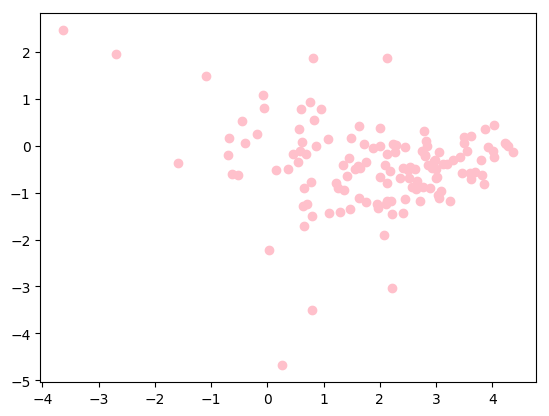

In [47]:
structure = 'Microtubules'
drug = 'Paclitaxel 5.0 μM'

c1 = ds['centroid'][structure][drug]['c1']
c2 = ds['centroid'][structure][drug]['c2']

# print(c1 = ds['centroid'][structure][drug]['c1'])

print(np.mean(position_dict[structure][drug]['positions'],0))

plt.scatter(position_dict[structure][drug]['positions'][:,0], position_dict[structure][drug]['positions'][:,1], color='pink')

c2-c1

In [48]:
c1 + ((c2-c1) * 10)

array([19.05649   , -6.8558846 ,  3.7647648 ,  0.77513194,  5.856397  ,
        3.3580217 ,  6.593171  ,  0.35855642, -3.8215697 , -0.8570653 ,
        9.38864   ,  0.47194985, -4.493479  ,  1.2160796 ,  0.45123595,
        0.5028421 ,  0.89721745,  0.07579248, -2.2847676 ,  3.3206668 ,
       -4.7258434 , -3.377382  , -0.8431272 ,  0.0598399 ,  1.913318  ,
       -2.2281227 ,  2.628757  ,  2.0509634 , -0.2841569 , -1.730087  ,
        2.2714784 ,  1.2043221 ], dtype=float32)

## Glamour plot along the direction of effect 

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/pytorch_integrated_cell/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


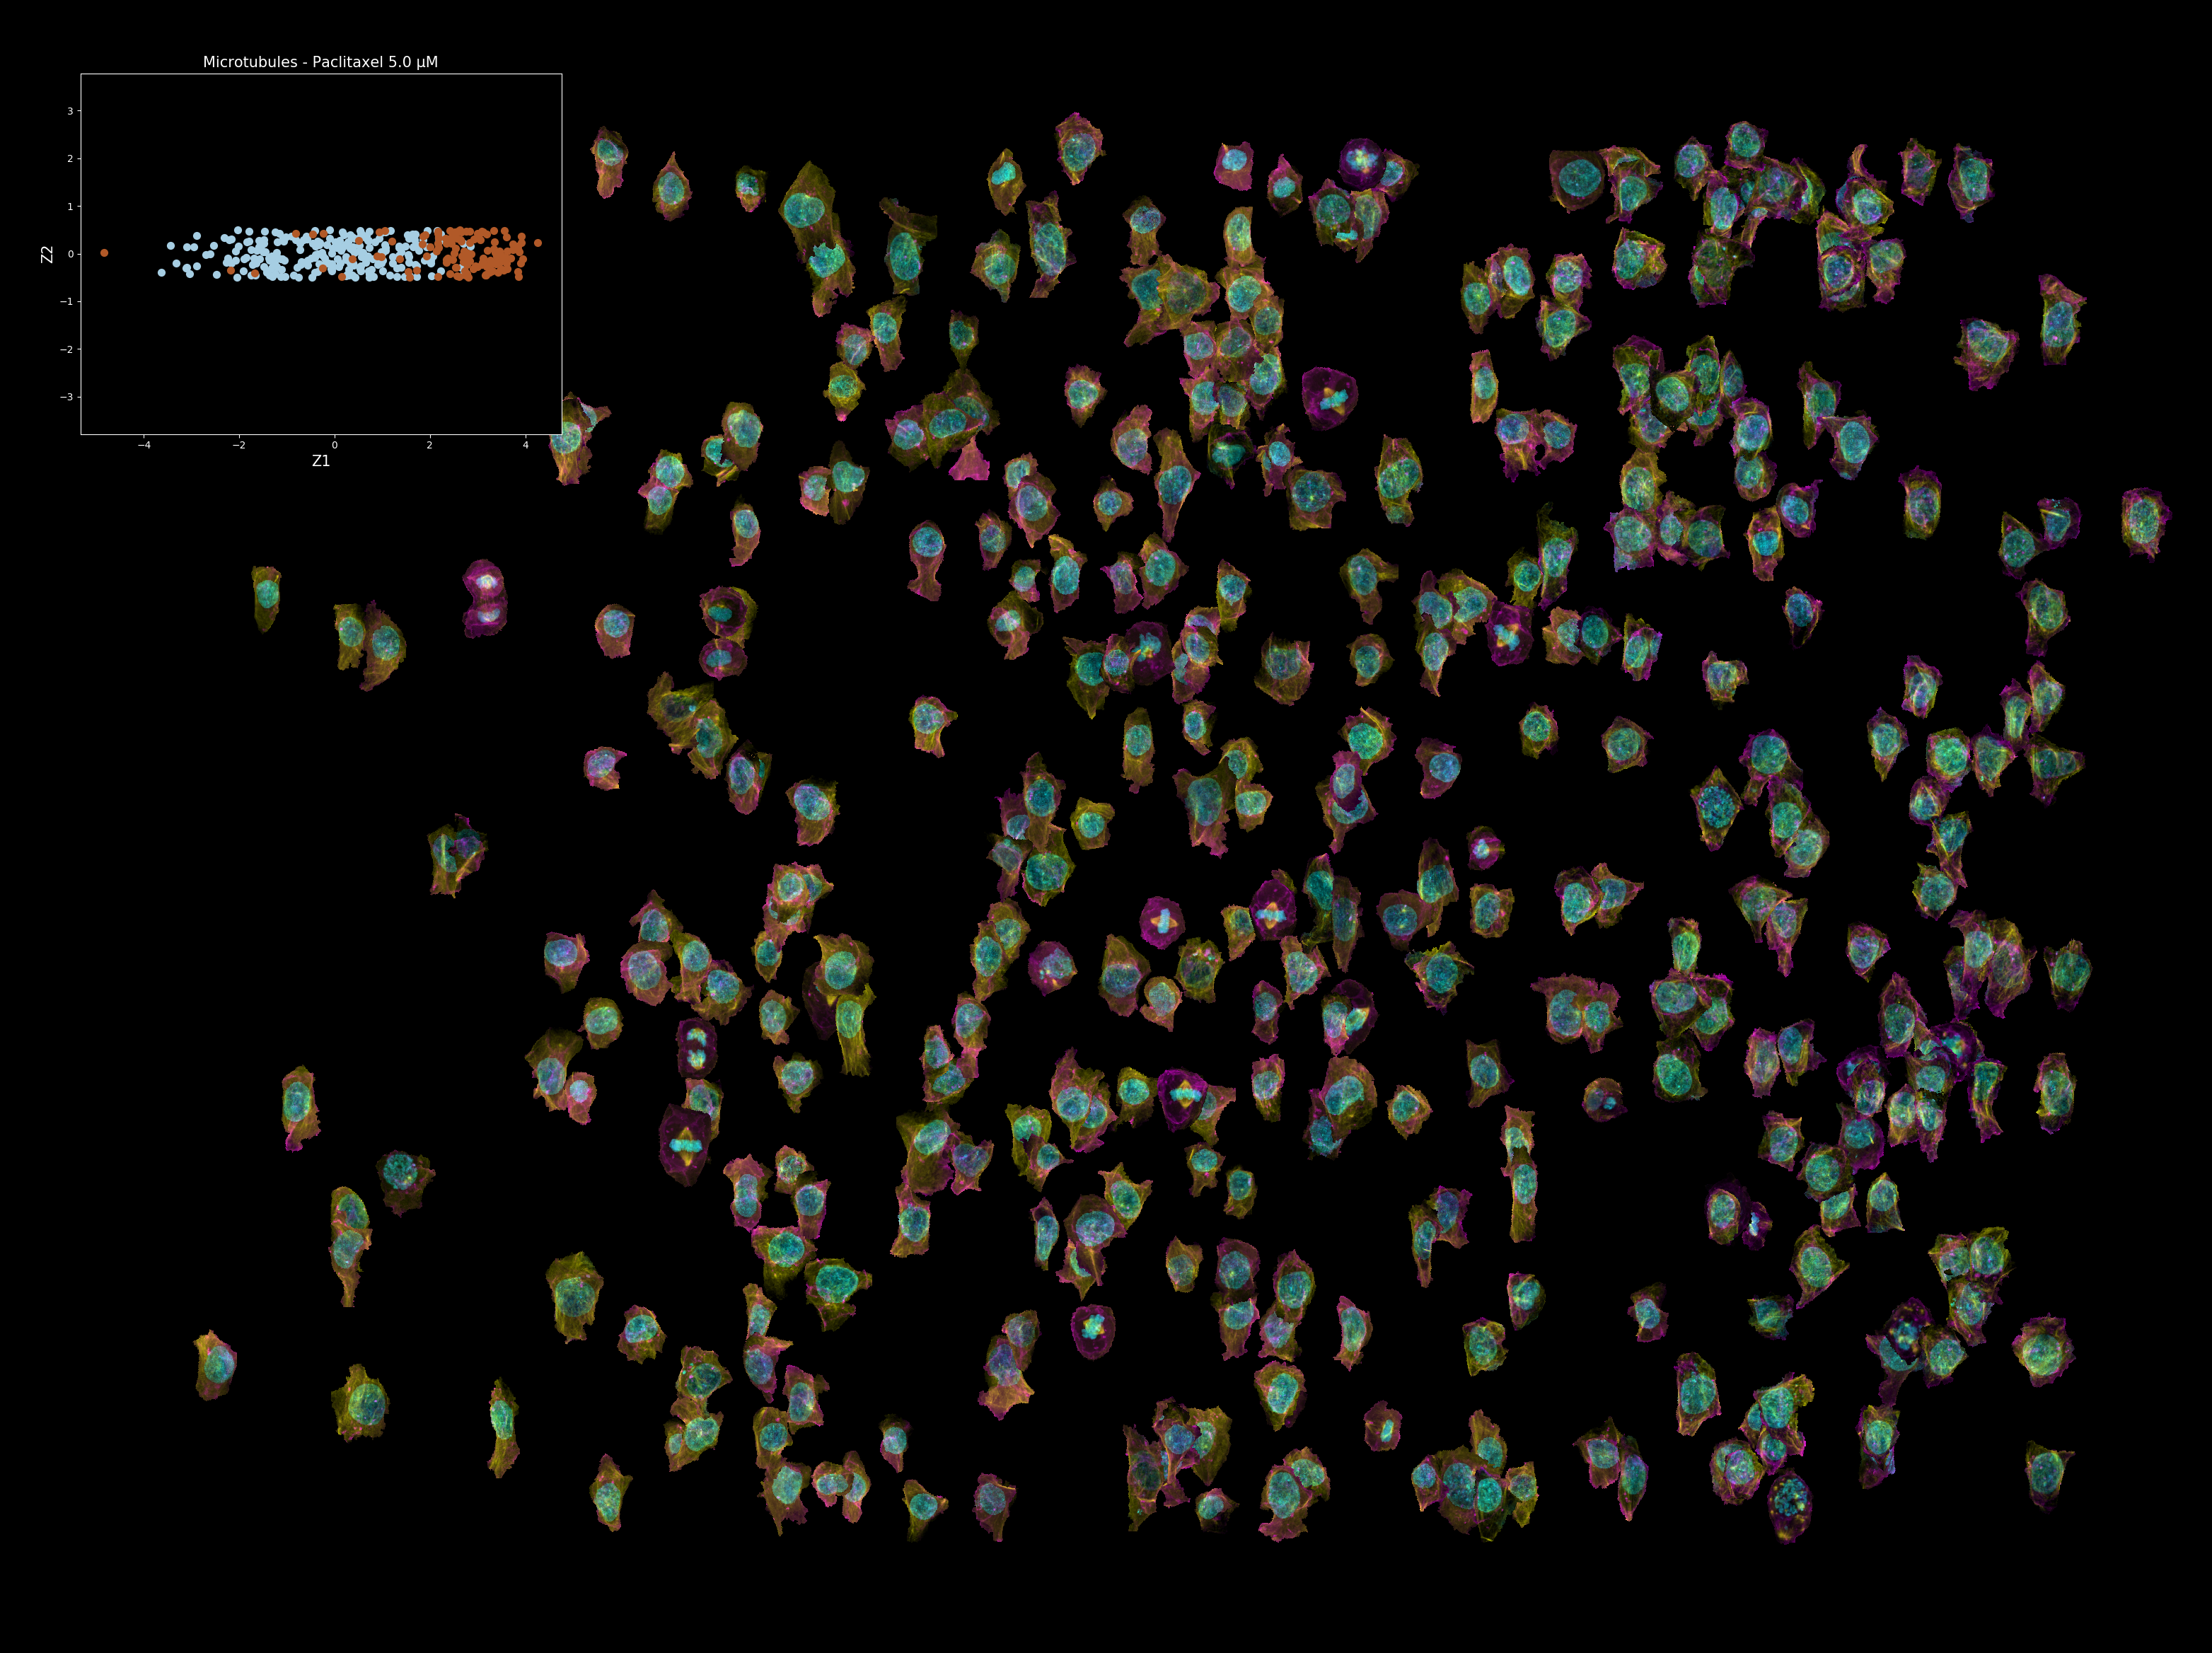

In [49]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter


from integrated_cell.utils.plots import scatter_im
from integrated_cell.utils.target import sample2im

def get_image(im_id, data_provider, train_or_test='test', channels_to_show = [1,1,1]):
    x, _ , ref = data_provider.get_sample(train_or_test, [im_id])
    
    im = sample2im(x, ref)
    
    im_out = tensor2im(im, proj_xy=False)
    
    alpha = np.expand_dims(np.any(im_out > 0,2).astype(im_out.dtype), 2)

    im_final = np.concatenate([im_out, alpha], 2)
    
    return im_final
    
zoom = 0.75

x_lb = -4.5
x_hb = 4.5

y_lb = -4.5
y_hb = 4.5

drug_name = 'Paclitaxel 5.0 μM'
structure = 'Microtubules'
train_or_test = 'test'

dims_meth = 'projection'

inset_colors = cm.Paired([0, 255])

plt.style.use('dark_background')
plt.figure(figsize=(40, 30))


c1 = ds['centroid'][structure][drug_name]['c1']
c2 = ds['centroid'][structure][drug_name]['c2']

vector = ds['centroid'][structure][drug_name]['vector']
sorted_dims = np.argsort(np.abs(vector))[::-1]

if dims_meth == 'sorted':
    p1 = position_dict[structure]['untreated']['positions'][:, sorted_dims[0:2]]
    p2 = position_dict[structure][drug_name]['positions'][:, sorted_dims[0:2]]
elif dims_meth == 'first_dims':
    p1 = position_dict[structure]['untreated']['positions'][:, 0:2]
    p2 = position_dict[structure][drug_name]['positions'][:, 0:2]
elif dims_meth == 'projection':
    p1 = position_dict[structure]['untreated']['positions']
    p2 = position_dict[structure][drug_name]['positions']
    
    c1 = ds['centroid'][structure][drug_name]['c1']
    c2 = ds['centroid'][structure][drug_name]['c2']
    
    vector = c2 - c1
    
    vector_norm = vector/np.linalg.norm(vector)
    
    p1 = np.vstack([np.dot(p1, vector_norm), np.random.rand(p1.shape[0]) - 0.5]).T
    p2 = np.vstack([np.dot(p2, vector_norm), np.random.rand(p2.shape[0]) - 0.5]).T
    
    y_lb = -0.6
    y_hb = 0.6
    

#plot the untreated
def myfunc(i):
    return get_image(position_dict[structure]['untreated']['dp_index'][i], dp_target)

ax, ax_inset = scatter_im(p1, myfunc, zoom = zoom, inset = True, inset_colors = inset_colors[0], inset_width_and_height=0.17, inset_scatter_size = 50, plot_range = [2, 98])

plt.sca(ax)

#plot the drugs
def myfunc(i):
    return get_image(position_dict[structure][drug_name]['dp_index'][i], dp_target_drugs)

ax, ax_inset = scatter_im(p2, myfunc, zoom = zoom, inset = True, inset_colors = inset_colors[1], inset_width_and_height=0.17, inset_scatter_size = 50, plot_range = [2, 98])


ax.set_xlim(x_lb, x_hb)    
ax.set_ylim(y_lb, y_hb)
plt.axis('equal')

ax_inset.set_xlim(x_lb, x_hb)    
ax_inset.set_ylim(y_lb, y_hb)
plt.axis('equal')

plt.ylabel('Z2', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.title("{} - {}".format(structure, drug_name), fontsize = 15)

# plt.savefig('{}/{}.png'.format(p_value_elbo_dir, label_to_print.replace('(', '').replace(')', '')), dpi=90, bbox_inches='tight')

plt.show()
plt.close()

plt.style.use('default')


In [50]:
for drug_structure in drug_structures:
    for drug in ['untreated'] + drugs:
        n_cells = position_dict[drug_structure][drug]['positions'].shape[0]
    
        print(f"{drug_structure} - {drug}: {n_cells}")

Microtubules - untreated: 242
Microtubules - Brefeldin 5.0 μM: 0
Microtubules - Paclitaxel 5.0 μM: 132
Golgi - untreated: 144
Golgi - Brefeldin 5.0 μM: 105
Golgi - Paclitaxel 5.0 μM: 23
Tight junctions - untreated: 105
Tight junctions - Brefeldin 5.0 μM: 94
Tight junctions - Paclitaxel 5.0 μM: 138


In [1]:
dp?

Object `dp` not found.
